# Domain adaptation for supervised integration of scRNA-seq data
This is a demo of our supervised integration algorithm based on pancreas data collection. You can directly execute all the cells to test this algorithm. The reason we use pancreas data collection as demo is that the other two data collections we used in our paper, PBMC and Gut contains much more cells and need higher RAM than what Google colab provides. 


1.   Code for training the supervised integration network. Need to be run in GPU mode: 

*   Click runtime->change runtime type->select GPU as hardware accelerator.
*   If you don't want to train a new network, we provide a well-trained model that can be tested directly.
*   t-SNE visualization code is provided after the training process, you can save the embedding features as csv file for further evaluations.


2.   Code for automated cell mapping

* Provide an example that takes Baron_b1 as query and integrates the other four batches as a comprehensive reference. And this emample takes Mutaro_b2 as target domain during the MNN based integration. You can change this setting for further testing.


In [1]:
import scanpy as sc
import scipy.io

import pandas as pd
import numpy   as np
import tensorflow as tf

### Supervised integration

#### load pancreas data, change the path to your own here

In [2]:
adata = pd.read_csv('./myData_pancreatic_5batches.txt',sep='\t',header=0, index_col=0)
adata = sc.AnnData(np.transpose(adata))
print(adata)
print(adata.obs_names[1:3])
print(adata.var_names[1:3])

AnnData object with n_obs × n_vars = 14767 × 15558
Index(['human1_lib1.final_cell_0002', 'human1_lib1.final_cell_0003'], dtype='object')
Index(['A1CF', 'A2M'], dtype='object')


In [3]:
d4_genes = list(adata.var_names)

#### load pancreas batch and cell type annotations, change the path to your own here

In [4]:
sample_adata = pd.read_csv('./mySample_pancreatic_5batches.txt',header=0, index_col=0, sep='\t')
print(sample_adata.values.shape)
print(sample_adata.keys())

(14767, 5)
Index(['batch', 'batchlb', 'celltype_orig', 'cellname', 'celltype'], dtype='object')


#### add annotations into the adata object

In [5]:
adata.obs['cell_type'] = sample_adata.loc[adata.obs_names,['celltype']]
adata.obs['batch'] = sample_adata.loc[adata.obs_names,['batchlb']]

#### Split batches

In [6]:
batch1 = adata[adata.obs["batch"] == "Baron_b1", :]
adata_0 = batch1.X
label_0 = adata.obs['cell_type'][adata.obs['batch']=='Baron_b1']
label_0 = label_0.to_list()

batch2 = adata[adata.obs["batch"] == "Mutaro_b2", :]
adata_1 = batch2.X
label_1 = adata.obs['cell_type'][adata.obs['batch']=='Mutaro_b2']
label_1 = label_1.to_list()

batch3 = adata[adata.obs["batch"] == "Segerstolpe_b3", :]
adata_2 = batch3.X
label_2 = adata.obs['cell_type'][adata.obs['batch']=='Segerstolpe_b3']
label_2 = label_2.to_list()

batch4 = adata[adata.obs["batch"] == "Wang_b4", :]
adata_3 = batch4.X
label_3 = adata.obs['cell_type'][adata.obs['batch']=='Wang_b4']
label_3 = label_3.to_list()

batch5 = adata[adata.obs["batch"] == "Xin_b5", :]
adata_4 = batch5.X
label_4 = adata.obs['cell_type'][adata.obs['batch']=='Xin_b5']
label_4 = label_4.to_list()

#### Show the cell type information of each batch

In [7]:
from collections import Counter  

In [8]:
Counter(list(label_0))

Counter({'acinar': 958,
         'beta': 2525,
         'delta': 601,
         'stellate': 457,
         'ductal': 1077,
         'alpha': 2326,
         'epsilon': 18,
         'gamma': 255,
         'endothelial': 252,
         'macrophage': 55,
         'schwann': 13,
         'mast': 25,
         't_cell': 7})

In [9]:
Counter(list(label_1))

Counter({'alpha': 812,
         'ductal': 245,
         'endothelial': 21,
         'delta': 193,
         'acinar': 219,
         'beta': 448,
         'gamma': 101,
         'mesenchymal': 80,
         'epsilon': 3})

In [10]:
Counter(list(label_2))

Counter({'delta': 114,
         'alpha': 886,
         'gamma': 197,
         'ductal': 386,
         'acinar': 185,
         'beta': 270,
         'MHC class II': 5,
         'stellate': 54,
         'endothelial': 16,
         'epsilon': 7,
         'mast': 7})

In [11]:
Counter(list(label_3))

Counter({'alpha': 190,
         'ductal': 96,
         'delta': 9,
         'beta': 111,
         'gamma': 18,
         'acinar': 6,
         'mesenchymal': 27})

In [12]:
Counter(list(label_4))

Counter({'beta': 472, 'alpha': 886, 'delta': 49, 'gamma': 85})

In [13]:
label_0_set = set(label_0)
label_1_set = set(label_1)
label_2_set = set(label_2)
label_3_set = set(label_3)
label_4_set = set(label_4)
print('cell type number of Baron_b1:',len(label_0_set))
print('cell type number of Mutaro_b2:',len(label_1_set))
print('cell type number of Segerstolpe_b3:',len(label_2_set))
print('cell type number of Wang_b4:',len(label_3_set))
print('cell type number of Xin_b5:',len(label_4_set))
all_list = list(label_0_set.union(label_1_set,label_2_set,label_3_set,label_4_set))
print('total cell type number:',len(all_list))
sub_list = list(label_0_set&label_2_set&label_1_set&label_3_set&label_4_set)
print('batch-shared cell type number:',len(sub_list))

cell type number of Baron_b1: 13
cell type number of Mutaro_b2: 9
cell type number of Segerstolpe_b3: 11
cell type number of Wang_b4: 7
cell type number of Xin_b5: 4
total cell type number: 15
batch-shared cell type number: 4


#### library size normailization and log transformation

In [14]:
import scprep
data_ln = scprep.normalize.library_size_normalize(adata_0)
adata_0_pre = scprep.transform.log(data_ln, pseudocount=1, base=10)
data_ln = scprep.normalize.library_size_normalize(adata_1)
adata_1_pre = scprep.transform.log(data_ln, pseudocount=1, base=10)
data_ln = scprep.normalize.library_size_normalize(adata_2)
adata_2_pre = scprep.transform.log(data_ln, pseudocount=1, base=10)
data_ln = scprep.normalize.library_size_normalize(adata_3)
adata_3_pre = scprep.transform.log(data_ln, pseudocount=1, base=10)
data_ln = scprep.normalize.library_size_normalize(adata_4)
adata_4_pre = scprep.transform.log(data_ln, pseudocount=1, base=10)

#### PCA

In [15]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(50)
adata_0_pca = pca.fit_transform(adata_0_pre)
print(adata_0_pca.shape)
adata_1_pca = pca.fit_transform(adata_1_pre)
print(adata_1_pca.shape)
adata_2_pca = pca.fit_transform(adata_2_pre)
print(adata_2_pca.shape)
adata_3_pca = pca.fit_transform(adata_3_pre)
print(adata_3_pca.shape)
adata_4_pca = pca.fit_transform(adata_4_pre)
print(adata_4_pca.shape)

(8569, 50)
(2122, 50)
(2127, 50)
(457, 50)
(1492, 50)


#### Siamese network g

In [16]:
import random
import os

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Convolution1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import sys


def printn(string):
    sys.stdout.write(string)
    sys.stdout.flush()


def Create_Model():

    img_rows = 50
    nb_filters = 32
    pool_size = 2
    kernel_size = 3
    input_shape = (img_rows,1)

    model = Sequential()
  

    model.add(Convolution1D(64, 5,padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))

    model.add(Convolution1D(64, 5,padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution1D(64, kernel_size,padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution1D(64, kernel_size,padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
 
    
    model.add(Convolution1D(nb_filters, kernel_size,padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution1D(nb_filters, kernel_size,padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution1D(nb_filters, kernel_size,padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution1D(nb_filters, 1, padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))

    model.add(Dropout(0.25))

    model.add(Convolution1D(nb_filters,1, padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Convolution1D(nb_filters,1, padding ='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))


    return model



def euclidean_distance(vects):
    eps = 1e-5
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), eps))



def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))




NameError: name 'backend_config' is not defined

#### Training function

In [24]:
def training_the_model(model):
    nb_classes=len(all_list)


    epoch = 15  # Epoch number
    batch_size = 512

    print ('Training the model - Epoch '+str(epoch))
    nn=batch_size
    best_Acc = 0
    for e in range(epoch):

        if e % 10 == 0:
            printn(str(e) + '->')
        for i in range(len(y2) // nn):##Align batch 1 and batch 2
            loss = model.train_on_batch([X12[i * nn:(i + 1) * nn, :], X2[i * nn:(i + 1) * nn, :]],
                                        [y12[i * nn:(i + 1) * nn, ], yc12[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X2[i * nn:(i + 1) * nn, :], X12[i * nn:(i + 1) * nn, :]],
                                        [y2[i * nn:(i + 1) * nn, ], yc12[i * nn:(i + 1) * nn, ]])
        for i in range(len(y3) // nn):##Align batch 1 and batch 3
            loss = model.train_on_batch([X13[i * nn:(i + 1) * nn, :],X3[i * nn:(i + 1) * nn, :]],
                                        [y13[i * nn:(i + 1) * nn,], yc13[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X3[i * nn:(i + 1) * nn, :],X13[i * nn:(i + 1) * nn, :]],
                                        [y3[i * nn:(i + 1) * nn,], yc13[i * nn:(i + 1) * nn, ]])
        for i in range(len(y4) // nn):##Align batch 1 and batch 4
            loss = model.train_on_batch([X14[i * nn:(i + 1) * nn, :],X4[i * nn:(i + 1) * nn, :]],
                                        [y14[i * nn:(i + 1) * nn,], yc14[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X4[i * nn:(i + 1) * nn, :],X14[i * nn:(i + 1) * nn, :]],
                                        [y4[i * nn:(i + 1) * nn,], yc14[i * nn:(i + 1) * nn, ]])
        for i in range(len(y5) // nn):##Align batch 1 and batch 5
            loss = model.train_on_batch([X15[i * nn:(i + 1) * nn, :],X5[i * nn:(i + 1) * nn, :]],
                                        [y15[i * nn:(i + 1) * nn,], yc15[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X5[i * nn:(i + 1) * nn, :],X15[i * nn:(i + 1) * nn, :]],
                                        [y5[i * nn:(i + 1) * nn,], yc15[i * nn:(i + 1) * nn, ]])    
        
        for i in range(len(y3_2) // nn):##Align batch 2 and batch 3
            loss = model.train_on_batch([X23[i * nn:(i + 1) * nn, :],X3_2[i * nn:(i + 1) * nn, :]],
                                        [y23[i * nn:(i + 1) * nn,], yc23[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X3_2[i * nn:(i + 1) * nn, :],X23[i * nn:(i + 1) * nn, :]],
                                        [y3_2[i * nn:(i + 1) * nn,], yc23[i * nn:(i + 1) * nn, ]])    
        for i in range(len(y4_2) // nn):##Align batch 2 and batch 4
            loss = model.train_on_batch([X24[i * nn:(i + 1) * nn, :],X4_2[i * nn:(i + 1) * nn, :]],
                                        [y24[i * nn:(i + 1) * nn,], yc24[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X4_2[i * nn:(i + 1) * nn, :],X24[i * nn:(i + 1) * nn, :]],
                                        [y4_2[i * nn:(i + 1) * nn,], yc24[i * nn:(i + 1) * nn, ]])
        for i in range(len(y5_2) // nn):##Align batch 2 and batch 5
            loss = model.train_on_batch([X25[i * nn:(i + 1) * nn, :],X5_2[i * nn:(i + 1) * nn, :]],
                                        [y25[i * nn:(i + 1) * nn,], yc25[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X5_2[i * nn:(i + 1) * nn, :],X25[i * nn:(i + 1) * nn, :]],
                                        [y5_2[i * nn:(i + 1) * nn,], yc25[i * nn:(i + 1) * nn, ]])
        for i in range(len(y4_3) // nn):##Align batch 3 and batch 4
            loss = model.train_on_batch([X34[i * nn:(i + 1) * nn, :],X4_3[i * nn:(i + 1) * nn, :]],
                                        [y34[i * nn:(i + 1) * nn,], yc34[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X4_3[i * nn:(i + 1) * nn, :],X34[i * nn:(i + 1) * nn, :]],
                                        [y4_3[i * nn:(i + 1) * nn,], yc34[i * nn:(i + 1) * nn, ]])
        for i in range(len(y5_3) // nn):##Align batch 3 and batch 5
            loss = model.train_on_batch([X35[i * nn:(i + 1) * nn, :],X5_3[i * nn:(i + 1) * nn, :]],
                                        [y35[i * nn:(i + 1) * nn,], yc35[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X5_3[i * nn:(i + 1) * nn, :],X35[i * nn:(i + 1) * nn, :]],
                                        [y5_3[i * nn:(i + 1) * nn,], yc35[i * nn:(i + 1) * nn, ]])
        for i in range(len(y5_4) // nn):##Align batch 4 and batch 5
            loss = model.train_on_batch([X45[i * nn:(i + 1) * nn, :],X5_4[i * nn:(i + 1) * nn, :]],
                                        [y45[i * nn:(i + 1) * nn,], yc45[i * nn:(i + 1) * nn, ]])
            loss = model.train_on_batch([X5_4[i * nn:(i + 1) * nn, :],X45[i * nn:(i + 1) * nn, :]],
                                        [y5_4[i * nn:(i + 1) * nn,], yc45[i * nn:(i + 1) * nn, ]])    
        ##monitor the classification accuracy
        Out_0 = model.predict([X_test_0, X_test_0])
        Acc_v_0 = np.argmax(Out_0[0], axis=1) - np.argmax(y_test_0, axis=1)

        Acc_0 = (len(Acc_v_0) - np.count_nonzero(Acc_v_0) + .0000001) / len(Acc_v_0)
        
        Out_1 = model.predict([X_test_1, X_test_1])
        Acc_v_1 = np.argmax(Out_1[0], axis=1) - np.argmax(y_test_1, axis=1)

        Acc_1 = (len(Acc_v_1) - np.count_nonzero(Acc_v_1) + .0000001) / len(Acc_v_1)

        Out_2 = model.predict([X_test_2, X_test_2])
        Acc_v_2 = np.argmax(Out_2[0], axis=1) - np.argmax(y_test_2, axis=1)

        Acc_2 = (len(Acc_v_2) - np.count_nonzero(Acc_v_2) + .0000001) / len(Acc_v_2)

        Out_3 = model.predict([X_test_3, X_test_3])
        Acc_v_3 = np.argmax(Out_3[0], axis=1) - np.argmax(y_test_3, axis=1)

        Acc_3 = (len(Acc_v_3) - np.count_nonzero(Acc_v_3) + .0000001) / len(Acc_v_3)

        Out_4 = model.predict([X_test_4, X_test_4])
        Acc_v_4 = np.argmax(Out_4[0], axis=1) - np.argmax(y_test_4, axis=1)

        Acc_4 = (len(Acc_v_4) - np.count_nonzero(Acc_v_4) + .0000001) / len(Acc_v_4)


        print('acc0='+ str(Acc_0)+'acc1='+ str(Acc_1)+' acc2='+ str(Acc_2)+' acc3='+ str(Acc_3)+'acc4='+ str(Acc_4)+'loss='+str(loss))
    print(str(e))
    return best_Acc

#### Generate training and testing cell set

In [17]:
label_0 = np.array(label_0)
label_1 = np.array(label_1)
label_2 = np.array(label_2)
label_3 = np.array(label_3)
label_4 = np.array(label_4)

In [18]:
l0_0 = list(np.where(label_0=='acinar')[0])
l1_0 = list(np.where(label_0=='alpha')[0])
l2_0 = list(np.where(label_0=='beta')[0])
l3_0 = list(np.where(label_0=='delta')[0])
l4_0 = list(np.where(label_0=='ductal')[0])
l5_0 = list(np.where(label_0=='endothelial')[0])
l6_0 = list(np.where(label_0=='epsilon')[0])
l7_0 = list(np.where(label_0=='gamma')[0])
l8_0 = list(np.where(label_0=='macrophage')[0])
l9_0 = list(np.where(label_0=='mast')[0])
l10_0 = list(np.where(label_0=='schwann')[0])
l11_0 = list(np.where(label_0=='stellate')[0])
l12_0 = list(np.where(label_0=='t_cell')[0])

In [19]:
l0_1 = list(np.where(label_1=='acinar')[0])
l1_1 = list(np.where(label_1=='alpha')[0])
l2_1 = list(np.where(label_1=='beta')[0])
l3_1 = list(np.where(label_1=='delta')[0])
l4_1 = list(np.where(label_1=='ductal')[0])
l5_1 = list(np.where(label_1=='endothelial')[0])
l6_1 = list(np.where(label_1=='epsilon')[0])
l7_1 = list(np.where(label_1=='gamma')[0])
l8_1 = list(np.where(label_1=='mesenchymal')[0])

In [20]:
l0_2 = list(np.where(label_2=='MHC class II')[0])
l1_2 = list(np.where(label_2=='acinar')[0])
l2_2 = list(np.where(label_2=='alpha')[0])
l3_2 = list(np.where(label_2=='beta')[0])
l4_2 = list(np.where(label_2=='delta')[0])
l5_2 = list(np.where(label_2=='ductal')[0])
l6_2 = list(np.where(label_2=='endothelial')[0])
l7_2 = list(np.where(label_2=='epsilon')[0])
l8_2 = list(np.where(label_2=='gamma')[0])
l9_2 = list(np.where(label_2=='mast')[0])
l10_2 = list(np.where(label_2=='stellate')[0])


In [21]:
l0_3 = list(np.where(label_3=='acinar')[0])
l1_3 = list(np.where(label_3=='alpha')[0])
l2_3 = list(np.where(label_3=='beta')[0])
l3_3 = list(np.where(label_3=='delta')[0])
l4_3 = list(np.where(label_3=='ductal')[0])
l5_3 = list(np.where(label_3=='gamma')[0])
l6_3 = list(np.where(label_3=='mesenchymal')[0])

In [22]:
l0_4 = list(np.where(label_4=='alpha')[0])
l1_4 = list(np.where(label_4=='beta')[0])
l2_4 = list(np.where(label_4=='delta')[0])
l3_4 = list(np.where(label_4=='gamma')[0])

In [23]:
cell_list_0 = [l0_0,l1_0,l2_0,l3_0,l4_0,l5_0,l6_0,l7_0,l8_0,l9_0,l10_0,l11_0,l12_0]
cell_list_1 = [l0_1,l1_1,l2_1,l3_1,l4_1,l5_1,l6_1,l7_1,l8_1]
cell_list_2 = [l0_2,l1_2,l2_2,l3_2,l4_2,l5_2,l6_2,l7_2,l8_2,l9_2,l10_2]
cell_list_3 = [l0_3,l1_3,l2_3,l3_3,l4_3,l5_3,l6_3]
cell_list_4 = [l0_4,l1_4,l2_4,l3_4]

In [24]:
###Sample batch 1 training data, 400 cells per cell type, test classification accuracy with all cells 
sample_num = 400 
sample_list_0 = []
for i in range(13):
  if len(cell_list_0[i])>=400:
    sample_list_0 = sample_list_0+random.sample(cell_list_0[i],sample_num)
  else:
    sample_list_0 = sample_list_0+cell_list_0[i]

X_train_0 = adata_0_pca[sample_list_0,:]
y_train_0 = np.array(label_0)[sample_list_0]

X0_test = adata_0_pca
y0_test = np.array(label_0)

In [25]:
###Sample batch 2 training data, 400 cells per cell type, test classification accuracy with all cells 
sample_num = 400
sample_list_1 = []
for i in range(9):
  if len(cell_list_1[i])>=400:
    sample_list_1 = sample_list_1+random.sample(cell_list_1[i],sample_num)
  else:
    sample_list_1 = sample_list_1+cell_list_1[i]

X_train_1 = adata_1_pca[sample_list_1,:]
y_train_1 = np.array(label_1)[sample_list_1]

X1_test = adata_1_pca
y1_test = np.array(label_1)

In [26]:
###Sample batch 3 training data, 400 cells per cell type, test classification accuracy with all cells 
sample_num = 400 
sample_list_2 = []
for i in range(11):
  if len(cell_list_2[i])>=400:
    sample_list_2 = sample_list_2+random.sample(cell_list_2[i],sample_num)
  else:
    sample_list_2 = sample_list_2+cell_list_2[i]

X_train_2 = adata_2_pca[sample_list_2,:]
y_train_2 = np.array(label_2)[sample_list_2]

X2_test = adata_2_pca
y2_test = np.array(label_2)

In [27]:
###Sample batch 4 training data, 400 cells per cell type, test classification accuracy with all cells 
sample_num = 400
sample_list_3 = []
for i in range(7):
  if len(cell_list_3[i])>=400:
    sample_list_3 = sample_list_3+random.sample(cell_list_3[i],sample_num)
  else:
    sample_list_3 = sample_list_3+cell_list_3[i]

X_train_3 = adata_3_pca[sample_list_3,:]
y_train_3 = np.array(label_3)[sample_list_3]

X3_test = adata_3_pca
y3_test = np.array(label_3)

In [28]:
###Sample batch 5 training data, 400 cells per cell type, test classification accuracy with all cells 
sample_num = 400 
sample_list_4 = []
for i in range(4):
  if len(cell_list_4[i])>=400:
    sample_list_4 = sample_list_4+random.sample(cell_list_4[i],sample_num)
  else:
    sample_list_4 = sample_list_4+cell_list_4[i]

X_train_4 = adata_4_pca[sample_list_4,:]
y_train_4 = np.array(label_4)[sample_list_4]

X4_test = adata_4_pca
y4_test = np.array(label_4)

#### encode training and testing labels

In [29]:
y_train_1=list(y_train_1)
y_train_2=list(y_train_2)
y_train_0=list(y_train_0)
y_train_3=list(y_train_3)
y_train_4=list(y_train_4)
y0_test = list(y0_test)
y1_test = list(y1_test)
y2_test = list(y2_test)
y3_test = list(y3_test)
y4_test = list(y4_test)

In [30]:
all_list = ['stellate',
 'macrophage',
 'gamma',
 'MHC class II',
 'delta',
 'epsilon',
 'mesenchymal',
 'endothelial',
 'ductal',
 'acinar',
 'mast',
 't_cell',
 'alpha',
 'beta',
 'schwann']

In [31]:
label_set_list = all_list
print(len(label_set_list))
label_code = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

15


In [32]:
for i in range(len(y_train_0)):
  for j in range(len(label_set_list)):
    if y_train_0[i] == label_set_list[j]:
      y_train_0[i] = label_code[j]
for i in range(len(y_train_1)):
  for j in range(len(label_set_list)):
    if y_train_1[i] == label_set_list[j]:
      y_train_1[i] = label_code[j] 
for i in range(len(y_train_2)):
  for j in range(len(label_set_list)):
    if y_train_2[i] == label_set_list[j]:
      y_train_2[i] = label_code[j]
for i in range(len(y_train_3)):
  for j in range(len(label_set_list)):
    if y_train_3[i] == label_set_list[j]:
      y_train_3[i] = label_code[j] 
for i in range(len(y_train_4)):
  for j in range(len(label_set_list)):
    if y_train_4[i] == label_set_list[j]:
      y_train_4[i] = label_code[j]                  

In [33]:
for i in range(len(y0_test)):
  for j in range(len(label_set_list)):
    if y0_test[i] == label_set_list[j]:
      y0_test[i] = label_code[j]
for i in range(len(y1_test)):
  for j in range(len(label_set_list)):
    if y1_test[i] == label_set_list[j]:
      y1_test[i] = label_code[j]
for i in range(len(y2_test)):
  for j in range(len(label_set_list)):
    if y2_test[i] == label_set_list[j]:
      y2_test[i] = label_code[j]
for i in range(len(y3_test)):
  for j in range(len(label_set_list)):
    if y3_test[i] == label_set_list[j]:
      y3_test[i] = label_code[j]
for i in range(len(y4_test)):
  for j in range(len(label_set_list)):
    if y4_test[i] == label_set_list[j]:
      y4_test[i] = label_code[j]            

#### Generate training pairs

In [ ]:
    ## Pairs for 1&2
    Training_P12=[]
    Training_N12=[]


    for tr0 in range(len(y_train_0)):
        for tr1 in range(len(y_train_1)):

            if y_train_0[tr0]==y_train_1[tr1]:
                Training_P12.append([tr0,tr1])
            else:
                Training_N12.append([tr0,tr1])


    random.shuffle(Training_N12)
    Training12 = Training_P12+Training_N12[:2*len(Training_P12)]
    random.shuffle(Training12)

In [ ]:
X12=np.zeros([len(Training12),50])
X2=np.zeros([len(Training12),50])


y12=np.zeros([len(Training12)])
y2=np.zeros([len(Training12)])

yc12=np.zeros([len(Training12)])

for i in range(len(Training12)):
    in1,in2=Training12[i]
    X12[i,:]=X_train_0[in1,:]
    X2[i,:]=X_train_1[in2,:]

    y12[i]=y_train_0[in1]
    y2[i]=y_train_1[in2]
    if y_train_0[in1]==y_train_1[in2]:
        yc12[i]=1



In [ ]:
del Training_N12,Training_P12,Training12
import gc
gc.collect()

50

In [ ]:
    #Pairs for 1&3
    
    Training_P13=[]
    Training_N13=[]


    for tr0 in range(len(y_train_0)):
        for tr2 in range(len(y_train_2)):

            if y_train_0[tr0]==y_train_2[tr2]:
                Training_P13.append([tr0,tr2])
            else:
                Training_N13.append([tr0,tr2])


    random.shuffle(Training_N13)
    Training13 = Training_P13+Training_N13[:2*len(Training_P13)]
    random.shuffle(Training13)

In [ ]:
X13=np.zeros([len(Training13),50])
X3=np.zeros([len(Training13),50])


y13=np.zeros([len(Training13)])
y3=np.zeros([len(Training13)])

yc13=np.zeros([len(Training13)])

for i in range(len(Training13)):
    in1,in3=Training13[i]
    X13[i,:]=X_train_0[in1,:]
    X3[i,:]=X_train_2[in3,:]

    y13[i]=y_train_0[in1]
    y3[i]=y_train_2[in3]
    if y_train_0[in1]==y_train_2[in3]:
        yc13[i]=1



In [ ]:
del Training_N13,Training_P13,Training13
gc.collect()

100

In [ ]:
    #Pairs for 1&4
    
    Training_P14=[]
    Training_N14=[]


    for tr0 in range(len(y_train_0)):
        for tr3 in range(len(y_train_3)):

            if y_train_0[tr0]==y_train_3[tr3]:
                Training_P14.append([tr0,tr3])
            else:
                Training_N14.append([tr0,tr3])


    random.shuffle(Training_N14)
    Training14 = Training_P14+Training_N14[:2*len(Training_P14)]
    random.shuffle(Training14)

In [ ]:
X14=np.zeros([len(Training14),50])
X4=np.zeros([len(Training14),50])


y14=np.zeros([len(Training14)])
y4=np.zeros([len(Training14)])

yc14=np.zeros([len(Training14)])

for i in range(len(Training14)):
    in1,in4=Training14[i]
    X14[i,:]=X_train_0[in1,:]
    X4[i,:]=X_train_3[in4,:]

    y14[i]=y_train_0[in1]
    y4[i]=y_train_3[in4]
    if y_train_0[in1]==y_train_3[in4]:
        yc14[i]=1

In [ ]:
del Training_N14,Training_P14,Training14
gc.collect()

50

In [ ]:
len(y_train_4)

934

In [ ]:
    #Pairs for 1&5
    
    Training_P15=[]
    Training_N15=[]


    for tr0 in range(len(y_train_0)):
        for tr4 in range(len(y_train_4)):

            if y_train_0[tr0]==y_train_4[tr4]:
                Training_P15.append([tr0,tr4])
            else:
                Training_N15.append([tr0,tr4])


    random.shuffle(Training_N15)
    Training15 = Training_P15+Training_N15[:2*len(Training_P15)]
    random.shuffle(Training15)

In [ ]:
X15=np.zeros([len(Training15),50])
X5=np.zeros([len(Training15),50])


y15=np.zeros([len(Training15)])
y5=np.zeros([len(Training15)])

yc15=np.zeros([len(Training15)])

for i in range(len(Training15)):
    in1,in5=Training15[i]
    X15[i,:]=X_train_0[in1,:]
    X5[i,:]=X_train_4[in5,:]

    y15[i]=y_train_0[in1]
    y5[i]=y_train_4[in5]
    if y_train_0[in1]==y_train_4[in5]:
        yc15[i]=1

In [ ]:
del Training_N15,Training_P15,Training15
gc.collect()

100

In [ ]:
    #Pairs for 2&3
    
    Training_P23=[]
    Training_N23=[]


    for tr1 in range(len(y_train_1)):
        for tr2 in range(len(y_train_2)):

            if y_train_1[tr1]==y_train_2[tr2]:
                Training_P23.append([tr1,tr2])
            else:
                Training_N23.append([tr1,tr2])


    random.shuffle(Training_N23)
    Training23 = Training_P23+Training_N23[:2*len(Training_P23)]
    random.shuffle(Training23)

In [ ]:
X23=np.zeros([len(Training23),50])
X3_2=np.zeros([len(Training23),50])


y23=np.zeros([len(Training23)])
y3_2=np.zeros([len(Training23)])

yc23=np.zeros([len(Training23)])

for i in range(len(Training23)):
    in2,in3=Training23[i]
    X23[i,:]=X_train_1[in2,:]
    X3_2[i,:]=X_train_2[in3,:]

    y23[i]=y_train_1[in2]
    y3_2[i]=y_train_2[in3]
    if y_train_1[in2]==y_train_2[in3]:
        yc23[i]=1



In [ ]:
del Training_N23,Training_P23,Training23
gc.collect()

103

In [ ]:
    #Pairs for 2&4
    
    Training_P24=[]
    Training_N24=[]


    for tr1 in range(len(y_train_1)):
        for tr3 in range(len(y_train_3)):

            if y_train_1[tr1]==y_train_3[tr3]:
                Training_P24.append([tr1,tr3])
            else:
                Training_N24.append([tr1,tr3])


    random.shuffle(Training_N24)
    Training24 = Training_P24+Training_N24[:2*len(Training_P24)]
    random.shuffle(Training24)

In [ ]:
X24=np.zeros([len(Training24),50])
X4_2=np.zeros([len(Training24),50])


y24=np.zeros([len(Training24)])
y4_2=np.zeros([len(Training24)])

yc24=np.zeros([len(Training24)])

for i in range(len(Training24)):
    in2,in4=Training24[i]
    X24[i,:]=X_train_1[in2,:]
    X4_2[i,:]=X_train_3[in4,:]

    y24[i]=y_train_1[in2]
    y4_2[i]=y_train_3[in4]
    if y_train_1[in2]==y_train_3[in4]:
        yc24[i]=1

In [ ]:
del Training_N24,Training_P24,Training24
gc.collect()

100

In [ ]:
    #Pairs for 2&5
    
    Training_P25=[]
    Training_N25=[]


    for tr1 in range(len(y_train_1)):
        for tr4 in range(len(y_train_4)):

            if y_train_1[tr1]==y_train_4[tr4]:
                Training_P25.append([tr1,tr4])
            else:
                Training_N25.append([tr1,tr4])


    random.shuffle(Training_N25)
    Training25 = Training_P25+Training_N25[:2*len(Training_P25)]
    random.shuffle(Training25)

In [ ]:
X25=np.zeros([len(Training25),50])
X5_2=np.zeros([len(Training25),50])


y25=np.zeros([len(Training25)])
y5_2=np.zeros([len(Training25)])

yc25=np.zeros([len(Training25)])

for i in range(len(Training25)):
    in2,in5=Training25[i]
    X25[i,:]=X_train_1[in2,:]
    X5_2[i,:]=X_train_4[in5,:]

    y25[i]=y_train_1[in2]
    y5_2[i]=y_train_4[in5]
    if y_train_1[in2]==y_train_4[in5]:
        yc25[i]=1

In [ ]:
del Training_N25,Training_P25,Training25
gc.collect()

100

In [ ]:
Training_P34=[]
Training_N34=[]


for tr2 in range(len(y_train_2)):
    for tr3 in range(len(y_train_3)):

        if y_train_2[tr2]==y_train_3[tr3]:
           Training_P34.append([tr2,tr3])
        else:
           Training_N34.append([tr2,tr3])


random.shuffle(Training_N34)
Training34 = Training_P34+Training_N34[:6*len(Training_P34)]
random.shuffle(Training34)
X34=np.zeros([len(Training34),50])
X4_3=np.zeros([len(Training34),50])


y34=np.zeros([len(Training34)])
y4_3=np.zeros([len(Training34)])

yc34=np.zeros([len(Training34)])

for i in range(len(Training34)):
    in3,in4=Training34[i]
    X34[i,:]=X_train_2[in3,:]
    X4_3[i,:]=X_train_3[in4,:]

    y34[i]=y_train_2[in3]
    y4_3[i]=y_train_3[in4]
    if y_train_2[in3]==y_train_3[in4]:
        yc34[i]=1

del Training_N34,Training_P34,Training34
gc.collect()

Training_P35=[]
Training_N35=[]


for tr2 in range(len(y_train_2)):
    for tr4 in range(len(y_train_4)):

        if y_train_2[tr2]==y_train_4[tr4]:
           Training_P35.append([tr2,tr4])
        else:
           Training_N35.append([tr2,tr4])


random.shuffle(Training_N35)
Training35 = Training_P35+Training_N35[:6*len(Training_P35)]
random.shuffle(Training35)
X35=np.zeros([len(Training35),50])
X5_3=np.zeros([len(Training35),50])


y35=np.zeros([len(Training35)])
y5_3=np.zeros([len(Training35)])

yc35=np.zeros([len(Training35)])

for i in range(len(Training35)):
    in3,in5=Training35[i]
    X35[i,:]=X_train_2[in3,:]
    X5_3[i,:]=X_train_4[in5,:]

    y35[i]=y_train_2[in3]
    y5_3[i]=y_train_4[in5]
    if y_train_2[in3]==y_train_4[in5]:
        yc35[i]=1

del Training_N35,Training_P35,Training35
gc.collect()


Training_P45=[]
Training_N45=[]


for tr3 in range(len(y_train_3)):
    for tr4 in range(len(y_train_4)):

        if y_train_3[tr3]==y_train_4[tr4]:
           Training_P45.append([tr3,tr4])
        else:
           Training_N45.append([tr3,tr4])


random.shuffle(Training_N45)
Training45 = Training_P45+Training_N45[:6*len(Training_P45)]
random.shuffle(Training45)
X45=np.zeros([len(Training45),50])
X5_4=np.zeros([len(Training45),50])


y45=np.zeros([len(Training45)])
y5_4=np.zeros([len(Training45)])

yc45=np.zeros([len(Training45)])

for i in range(len(Training45)):
    in4,in5=Training45[i]
    X45[i,:]=X_train_3[in4,:]
    X5_4[i,:]=X_train_4[in5,:]

    y45[i]=y_train_3[in4]
    y5_4[i]=y_train_4[in5]
    if y_train_3[in4]==y_train_4[in5]:
        yc45[i]=1

del Training_N45,Training_P45,Training45
gc.collect()

0

In [ ]:
    nb_classes=len(all_list)
    X12 = X12.reshape(X12.shape[0], 50,1)
    X13 = X13.reshape(X13.shape[0], 50,1)
    X14 = X14.reshape(X14.shape[0], 50,1)
    X15 = X15.reshape(X15.shape[0], 50,1)
    X23 = X23.reshape(X23.shape[0], 50,1)
    X24 = X24.reshape(X24.shape[0], 50,1)
    X25 = X25.reshape(X25.shape[0], 50,1)
    X2 = X2.reshape(X2.shape[0], 50,1)
    X3 = X3.reshape(X3.shape[0], 50,1)
    X34 = X34.reshape(X34.shape[0], 50,1)
    X35 = X35.reshape(X35.shape[0], 50,1)
    X4 = X4.reshape(X4.shape[0], 50,1)
    X5 = X5.reshape(X5.shape[0], 50,1)
    X45 = X45.reshape(X45.shape[0], 50,1)
    X3_2 = X3_2.reshape(X3_2.shape[0], 50,1)
    X4_2 = X4_2.reshape(X4_2.shape[0], 50,1)
    X5_2 = X5_2.reshape(X5_2.shape[0], 50,1)
    X4_3 = X4_3.reshape(X4_3.shape[0], 50,1)
    X5_3 = X5_3.reshape(X5_3.shape[0], 50,1)
    X5_4 = X5_4.reshape(X5_4.shape[0], 50,1)
    X_test_0 = X0_test
    y_test_0 = y0_test
    X_test_0 = X_test_0.reshape(X_test_0.shape[0], 50,1)
    y_test_0 = np_utils.to_categorical(y_test_0, nb_classes)

    X_test_1 = X1_test
    y_test_1 = y1_test
    X_test_1 = X_test_1.reshape(X_test_1.shape[0], 50,1)
    y_test_1 = np_utils.to_categorical(y_test_1, nb_classes)

    X_test_2 = X2_test
    y_test_2 = y2_test
    X_test_2 = X_test_2.reshape(X_test_2.shape[0], 50,1)
    y_test_2 = np_utils.to_categorical(y_test_2, nb_classes)

    X_test_3 = X3_test
    y_test_3 = y3_test
    X_test_3 = X_test_3.reshape(X_test_3.shape[0], 50,1)
    y_test_3 = np_utils.to_categorical(y_test_3, nb_classes)

    X_test_4 = X4_test
    y_test_4 = y4_test
    X_test_4 = X_test_4.reshape(X_test_4.shape[0], 50,1)
    y_test_4 = np_utils.to_categorical(y_test_4, nb_classes)

    y12 = utils.to_categorical(y12, nb_classes)
    y13 = utils.to_categorical(y13, nb_classes)
    y14 = utils.to_categorical(y14, nb_classes)
    y15 = utils.to_categorical(y15, nb_classes)
    y23 = utils.to_categorical(y23, nb_classes)
    y24 = utils.to_categorical(y24, nb_classes)
    y25 = utils.to_categorical(y25, nb_classes)
    y34 = utils.to_categorical(y34, nb_classes)
    y35 = utils.to_categorical(y35, nb_classes)
    y45 = utils.to_categorical(y45, nb_classes)
    y2 = utils.to_categorical(y2, nb_classes)
    y3 = utils.to_categorical(y3, nb_classes)
    y4 = utils.to_categorical(y4, nb_classes)
    y5 = utils.to_categorical(y5, nb_classes)
    y3_2 = utils.to_categorical(y3_2, nb_classes)
    y4_2 = utils.to_categorical(y4_2, nb_classes)
    y5_2 = utils.to_categorical(y5_2, nb_classes)
    y4_3 = utils.to_categorical(y4_3, nb_classes)
    y5_3 = utils.to_categorical(y5_3, nb_classes)
    y5_4 = utils.to_categorical(y5_4, nb_classes)

# Create siamese network branch g
model1=Create_Model()

In [32]:
img_rows= 50
input_shape = (img_rows, 1)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)


# number of classes for digits classification
nb_classes = len(all_list)

# Loss = (1-alpha)Classification_Loss + (alpha)CSA
alpha = .6

# Having two branches. One for source and one for target.
processed_a = model1(input_a)
processed_b = model1(input_b)


# Creating the prediction function. This corresponds to h in the paper.
out1 = Dropout(0.5)(processed_a)
out1 = Dense(64,activation='relu')(out1)
out1 = Dense(32,activation='relu')(out1)

out1 = Dense(nb_classes)(out1)
out1 = Activation('softmax', name='classification')(out1)


distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape, name='CSA')(
    [processed_a, processed_b])
model = Model(inputs=[input_a, input_b], outputs=[out1, distance])
model.compile(loss={'classification': 'categorical_crossentropy', 'CSA': contrastive_loss},
              optimizer=tf.keras.optimizers.Adam(0.00001),
              loss_weights={'classification': 1 - alpha, 'CSA': alpha})


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           343232      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 64)           0           ['sequential[0][0]']             
                                                                                                  
 dense_3 (Dense)                (None, 64)           4160        ['dropout_3[0][0]']          

#### If you don't want to train a new model, a well-trained model is provided 

In [34]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Domain adaptation for supervised integration of scRNA-seq data/models/model.h5",custom_objects={'contrastive_loss':contrastive_loss})

#### Train the model
if using the provided well-trained model,do not run the cell below

In [ ]:
Acc=training_the_model(model)

Training the model - Epoch 30
0->

KeyboardInterrupt: ignored

#### Save the model
if using the provided well-trained model,do not run the cell below

In [ ]:
model.save('/content/drive/MyDrive/Domain adaptation for supervised integration of scRNA-seq data/models/model.h5')

In [ ]:
model1.save('/content/drive/MyDrive/Domain adaptation for supervised integration of scRNA-seq data/models/model1.h5')

#### t-sne visualization

In [45]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [46]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

In [100]:
temp = np.concatenate((adata_0_pca,adata_1_pca),axis=0)
temp = np.concatenate((temp,adata_2_pca),axis=0)
temp = np.concatenate((temp,adata_3_pca),axis=0)
X_test = np.concatenate((temp,adata_4_pca),axis=0)
y_batch = [0]*len(list(label_0))+[1]*len(list(label_1))+[2]*len(list(label_2))+[3]*len(list(label_3))+[4]*len(list(label_4))
y_celltype = list(label_0)+list(label_1)+list(label_2)+list(label_3)+list(label_4)
dense1_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer('dense_4').output)
X_test = X_test.reshape(X_test.shape[0], 50,1)

for i in range(len(y_celltype)):
  for j in range(len(label_set_list)):
    if y_celltype[i] == label_set_list[j]:
      y_celltype[i] = label_code[j]

Out = dense1_layer_model.predict([X_test,X_test])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


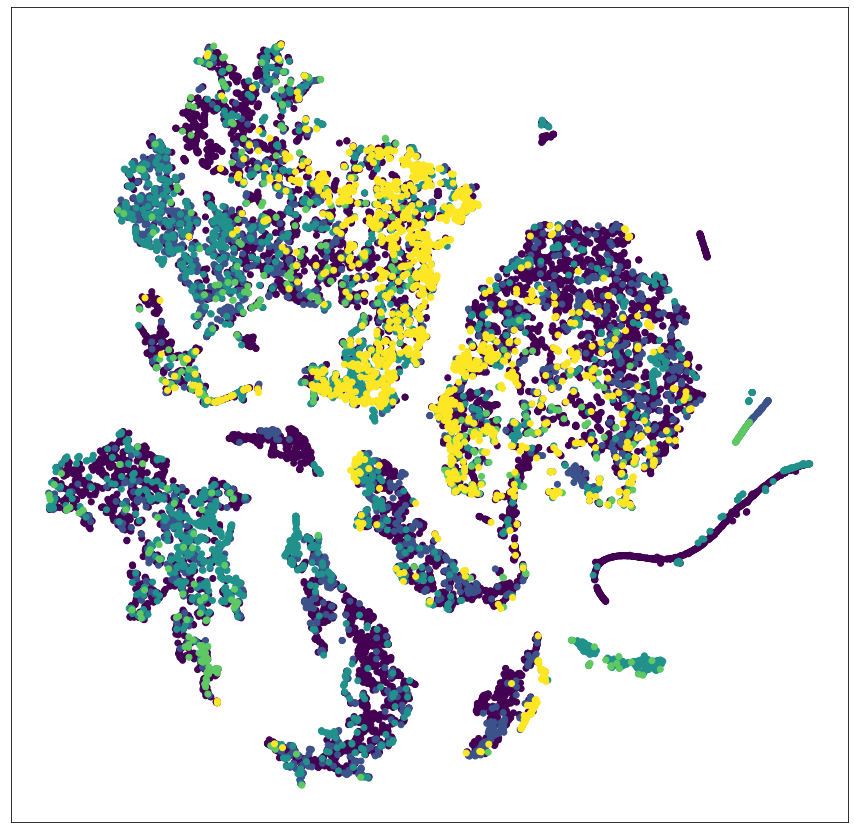

In [47]:
'''batch t-SNE'''
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(Out)
 
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min) 
plt.figure(figsize=(15, 15))

plt.scatter(X_norm[:, 0], X_norm[:, 1],c=y_batch) 

plt.xticks([])
plt.yticks([])

plt.show()

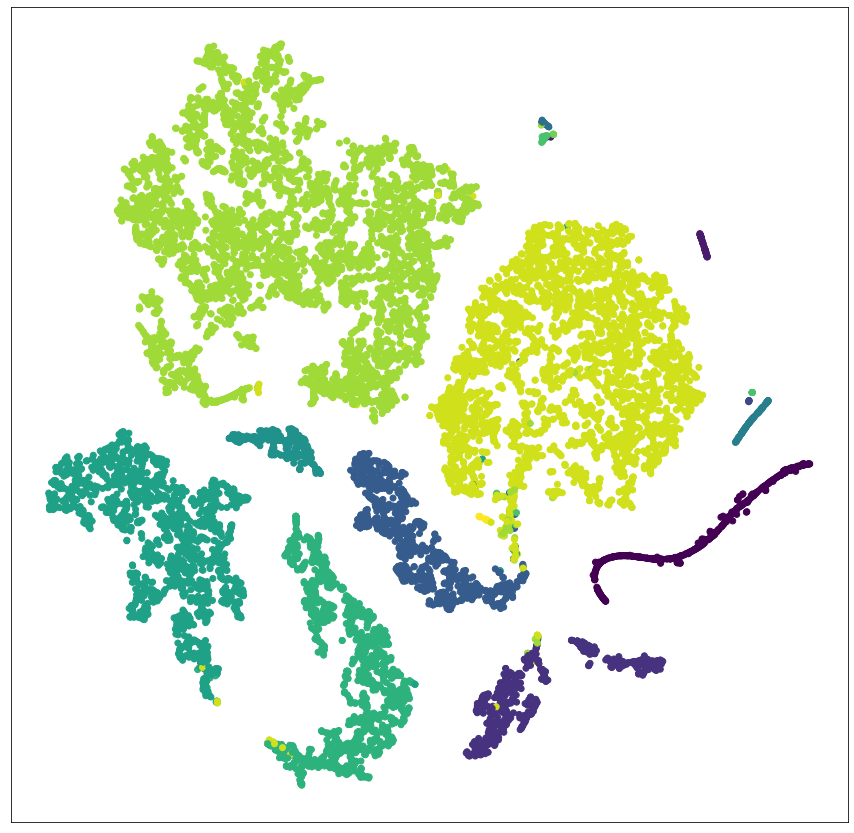

In [48]:
'''celltype t-SNE'''
plt.figure(figsize=(15, 15))

plt.scatter(X_norm[:, 0], X_norm[:, 1],c=y_celltype) 

plt.xticks([])
plt.yticks([])

plt.show()

## automated cell type mapping

#### define seurat integration functions in python

In [49]:
!pip install nmslib
from copy import deepcopy
import nmslib
import numpy as np
import pandas as pd
from scipy.sparse import load_npz
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from statsmodels.nonparametric.smoothers_lowess import lowess


np.random.seed(1)
np.set_printoptions(suppress=True, linewidth=800, precision=3, edgeitems=25)



def approximate_nearest_neighbors_nmslib(reference, query, k, ef, ef_construction=2000, M=100):
    index = nmslib.init(method='hnsw', space='l2')
    index.addDataPointBatch(reference)
    index.createIndex({'M': M, 'indexThreadQty': 1, 'efConstruction': ef_construction, 'post': 0}, print_progress=False)
    index.setQueryTimeParams({'efSearch': ef})
    results = index.knnQueryBatch(query, k=k, num_threads=1)
    shape = (len(query), k)
    idxs = np.zeros(shape).astype('int')
    distances = np.zeros(shape)
    for i in range(len(results)):
        idxs[i, :] = results[i][0]
        distances[i, :] = results[i][1]
    return idxs, distances


def get_anchor_weights_by_query_cell(query_matrix_for_transfer_weights, anchor_query_cells, anchor_scores, kweight=50, sd=1):
    query_kn_query_anchor_idxs, query_kn_query_anchor_distances = approximate_nearest_neighbors_nmslib(
        reference=query_matrix_for_transfer_weights[anchor_query_cells],
        query=query_matrix_for_transfer_weights, k=kweight,
        ef=int(kweight * 1.5), ef_construction=int(kweight * 1.5), M=50)

    column_idxs = np.arange(len(query_matrix_for_transfer_weights))[:, None]
    anchor_weights_by_query_cell = np.zeros((len(anchor_query_cells), len(query_matrix_for_transfer_weights)))

    query_kn_query_anchor_distances_weighted = 1 - query_kn_query_anchor_distances / (query_kn_query_anchor_distances[:, -1][:, None])

    anchor_weights_by_query_cell[query_kn_query_anchor_idxs, column_idxs] = query_kn_query_anchor_distances_weighted
    anchor_weights_by_query_cell = anchor_weights_by_query_cell * anchor_scores[:, None]
    anchor_weights_by_query_cell[query_kn_query_anchor_idxs, column_idxs] = 1 - np.exp(
            -anchor_weights_by_query_cell[query_kn_query_anchor_idxs, column_idxs] / ((2 / sd) ** 2))
    anchor_weights_by_query_cell = anchor_weights_by_query_cell / np.sum(anchor_weights_by_query_cell, axis=0)

    return anchor_weights_by_query_cell


def get_initial_anchors(reference_kn_query, query_kn_reference, mnn_n=5):
    anchors = []
    for reference_cell in range(len(reference_kn_query)):
        closest_queries_to_reference = reference_kn_query[reference_cell][:mnn_n]
        for closest_query_to_reference in closest_queries_to_reference:
            closest_references_to_query = query_kn_reference[closest_query_to_reference][:mnn_n]
            for closest_reference_to_query in closest_references_to_query:
                if closest_reference_to_query == reference_cell:
                    anchors.append([reference_cell, closest_query_to_reference])
    anchors = np.array(anchors).astype('int')
    return anchors


def score_anchors(anchors, reference_kn_reference, reference_kn_query, query_kn_reference, query_kn_query):
    offset = len(reference_kn_reference)

    anchor_scores = np.zeros(len(anchors)).astype('int')
    for anchor_idx in range(len(anchor_scores)):
        reference_cell = anchors[anchor_idx, 0]
        query_cell = anchors[anchor_idx, 1]
        reference_neighbor_set = list(reference_kn_reference[reference_cell]) + list(reference_kn_query[reference_cell] + offset)
        query_neighbor_set = list(query_kn_reference[query_cell]) + list(query_kn_query[query_cell] + offset)
        anchor_scores[anchor_idx] = len(list(set(reference_neighbor_set) & set(query_neighbor_set)))

    max_score = np.percentile(anchor_scores, 90)
    min_score = np.percentile(anchor_scores, 1)

    anchor_scores = anchor_scores - min_score
    anchor_scores = anchor_scores / (max_score - min_score)
    anchor_scores[anchor_scores > 1] = 1
    anchor_scores[anchor_scores < 0] = 0
    return anchor_scores

def get_batch_corrected_query(matrix_ref,matrix_query, anchor_query_cells, anchor_reference_cells, anchor_weights_by_query_cell):
    integration_matrix = matrix_query[anchor_query_cells] - matrix_ref[anchor_reference_cells]
    correction_matrix = np.matmul(integration_matrix.T, anchor_weights_by_query_cell).T
    query_matrix_corrected = matrix_query - correction_matrix
    return query_matrix_corrected

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 5.0 MB/s 
     |████████████████████████████████| 188 kB 67.8 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Get the embedding features for each domain
In this example, we take Baron_b1 as query, and integrate the other four batches(Mutaro_b2 as target domain). 


In [101]:
b1_list = list(np.where(np.array(y_batch)==1)[0])
b2_list = list(np.where(np.array(y_batch)==2)[0])
b3_list = list(np.where(np.array(y_batch)==3)[0])
b4_list = list(np.where(np.array(y_batch)==4)[0])

In [102]:
len(b1_list)

2122

In [103]:
Out_1 = Out.T[:,b1_list]
Out_2 = Out.T[:,b2_list]
Out_3 = Out.T[:,b3_list]
Out_4 = Out.T[:,b4_list]

#### first, integrate batch1,2,3,4

In [104]:
mnn_n = 3
k_score = 10
k = max(mnn_n, k_score)

In [105]:
## integrate batch 2 to batch 1 domain
query_reduced_l2 = Out_2.T
reference_reduced_l2 = Out_1.T
query_kn_reference, _ = approximate_nearest_neighbors_nmslib(reference=reference_reduced_l2, query=query_reduced_l2, k=k, ef=2000, ef_construction=2000, M=100)
reference_kn_query, _ = approximate_nearest_neighbors_nmslib(reference=query_reduced_l2, query=reference_reduced_l2, k=k, ef=2000,ef_construction=2000, M=100)
query_kn_query, _ = approximate_nearest_neighbors_nmslib(reference=query_reduced_l2, query=query_reduced_l2, k=k_score, ef=2000,ef_construction=2000, M=100)
reference_kn_reference, _ = approximate_nearest_neighbors_nmslib(reference=reference_reduced_l2, query=reference_reduced_l2, k=k_score, ef=2000,ef_construction=2000, M=100)
anchors = get_initial_anchors(reference_kn_query, query_kn_reference, mnn_n)
anchor_scores = score_anchors(anchors, reference_kn_reference, reference_kn_query, query_kn_reference, query_kn_query)
anchor_reference_cells = anchors[:, 0]
anchor_query_cells = anchors[:, 1]
anchor_weights_by_query_cell = get_anchor_weights_by_query_cell(query_reduced_l2, anchor_query_cells, anchor_scores=anchor_scores, kweight=15)
query_matrix_corrected = get_batch_corrected_query(adata_1_pre,adata_2_pre,anchor_query_cells, anchor_reference_cells, anchor_weights_by_query_cell)
adata_2_corrected = query_matrix_corrected

In [106]:
## integrate batch 3 to batch 1 domain
query_reduced_l2 = Out_3.T
reference_reduced_l2 = Out_1.T
query_kn_reference, _ = approximate_nearest_neighbors_nmslib(reference=reference_reduced_l2, query=query_reduced_l2, k=k, ef=2000, ef_construction=2000, M=100)
reference_kn_query, _ = approximate_nearest_neighbors_nmslib(reference=query_reduced_l2, query=reference_reduced_l2, k=k, ef=2000,ef_construction=2000, M=100)
query_kn_query, _ = approximate_nearest_neighbors_nmslib(reference=query_reduced_l2, query=query_reduced_l2, k=k_score, ef=2000,ef_construction=2000, M=100)
reference_kn_reference, _ = approximate_nearest_neighbors_nmslib(reference=reference_reduced_l2, query=reference_reduced_l2, k=k_score, ef=2000,ef_construction=2000, M=100)
anchors = get_initial_anchors(reference_kn_query, query_kn_reference, mnn_n)
anchor_scores = score_anchors(anchors, reference_kn_reference, reference_kn_query, query_kn_reference, query_kn_query)
anchor_reference_cells = anchors[:, 0]
anchor_query_cells = anchors[:, 1]
anchor_weights_by_query_cell = get_anchor_weights_by_query_cell(query_reduced_l2, anchor_query_cells, anchor_scores=anchor_scores, kweight=15)
query_matrix_corrected = get_batch_corrected_query(adata_1_pre,adata_3_pre,anchor_query_cells, anchor_reference_cells, anchor_weights_by_query_cell)
adata_3_corrected = query_matrix_corrected


In [107]:
## integrate batch 4 to batch 1 domain
query_reduced_l2 = Out_4.T
reference_reduced_l2 = Out_1.T
query_kn_reference, _ = approximate_nearest_neighbors_nmslib(reference=reference_reduced_l2, query=query_reduced_l2, k=k, ef=2000, ef_construction=2000, M=100)
reference_kn_query, _ = approximate_nearest_neighbors_nmslib(reference=query_reduced_l2, query=reference_reduced_l2, k=k, ef=2000,ef_construction=2000, M=100)
query_kn_query, _ = approximate_nearest_neighbors_nmslib(reference=query_reduced_l2, query=query_reduced_l2, k=k_score, ef=2000,ef_construction=2000, M=100)
reference_kn_reference, _ = approximate_nearest_neighbors_nmslib(reference=reference_reduced_l2, query=reference_reduced_l2, k=k_score, ef=2000,ef_construction=2000, M=100)
anchors = get_initial_anchors(reference_kn_query, query_kn_reference, mnn_n)
anchor_scores = score_anchors(anchors, reference_kn_reference, reference_kn_query, query_kn_reference, query_kn_query)
anchor_reference_cells = anchors[:, 0]
anchor_query_cells = anchors[:, 1]
anchor_weights_by_query_cell = get_anchor_weights_by_query_cell(query_reduced_l2, anchor_query_cells, anchor_scores=anchor_scores, kweight=15)
query_matrix_corrected = get_batch_corrected_query(adata_1_pre,adata_4_pre,anchor_query_cells, anchor_reference_cells, anchor_weights_by_query_cell)
adata_4_corrected = query_matrix_corrected

In [108]:
## concatenate the integrated high-dimensional batches
temp = np.concatenate((adata_1_pre,adata_2_corrected),axis=0)
temp = np.concatenate((temp,adata_3_corrected),axis=0)
X_test = np.concatenate((temp,adata_4_corrected),axis=0)

##### second, do automated cell type mapping using scanpy


In [109]:
adata_ref_celltype = list(label_1)+list(label_2)+list(label_3)+list(label_4)
adata_celltype = list(label_0)

In [110]:
obs = pd.DataFrame()
obs['celltype'] = adata_ref_celltype
var_names =d4_genes
# number of variables
n_vars = len(var_names)
# dataframe for annotating the variables
var = pd.DataFrame(index=var_names)
# the data matrix of shape n_obs x n_vars
X =np.array(X_test)
adata_ref = sc.AnnData(X, obs=obs, var=var)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [111]:
obs = pd.DataFrame()
obs['celltype'] = adata_celltype
var_names = d4_genes
# number of variables
n_vars = len(var_names)
# dataframe for annotating the variables
var = pd.DataFrame(index=var_names)
# the data matrix of shape n_obs x n_vars
X =np.array(adata_0_pre)
adata = sc.AnnData(X, obs=obs, var=var)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [112]:
sc.pp.highly_variable_genes(adata)
sc.pp.highly_variable_genes(adata_ref)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [113]:

hvg = (adata.var['highly_variable']&(adata_ref.var['highly_variable']))

adata = adata[:,hvg]
adata_ref = adata_ref[:,hvg]

In [114]:
sc.pp.neighbors(adata_ref)
sc.pp.pca(adata_ref)

sc.tl.umap(adata_ref)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [115]:
sc.tl.ingest(adata, adata_ref,obs='celltype')

In [116]:
mapping_res = adata.obs['celltype']

In [117]:
a = sum((mapping_res)==(adata_celltype))

In [118]:
a/len(adata_celltype)

0.8894853541836854